----
Titanic exercise
----
----
The objective is to predict if a passenger will survive the crash with the iceberg, in function of several instances.  
Instances available are :  
  * PassengerId : Index of the passenger in the set
  * Survived : 0 if not survived, 1 if Survived
  * Pclass : the onboard class of the passenger, from 1 to 3
  * Name : Passenger's name
  * Sex : Passenger's gender
  * Age : Passenger's age
  * SibSp : 1 if the passenger has Sibling or spouse onboard, 0 if not.
  * ParCh : 1 if the passenger has Parent or children onboard, 0 if not.
  * Ticket : Ticket number
  * Fare : Ticket charge
  * Cabin : Cabin number
  * Embarked : Embarkation port, C = Cherbourg, Q = Queenstown, S = Southampton  
  
The output of the model will be (when a test set is inputed):
  * PassengerId
  * Survived prediction, 

I - Frame the problem and look at the big picture.
---
---
**1. Define the objective in business term.**  
The objective is to produce a prediction of the passenger survival in function of several parameters.

**2. How your solution will be used?** 
The user will pass a csv table as input and the output must be a csv table with the prediction of passenger survival corresponding to the passengerId of the input table

**3. What are the current solution/workarounds?**  
Go check later on Kaggle.com

**4. How should you frame this problem (supervised/unsupervised learning, online/offline, etc.) ?**  
It's a classification task with supervised and offline learning.  

**5. How should the performance be measured ?**  
In order to measure the performance, the prediction of survival will be compared to the reality in the test and train set.

**6. Is the performance measured aligned with the business objectives ?**  
Yes.

**7. What would be the minimum performance needed to reac the business objectives ?**  
The minimum rate for performance is 0.9

**8. What are the comparable problem ?**  
It's a classical classification task, it could be eventually resolved as a regression task

**9. Is human expertise available?**  
Not really.

**10. How would you solve the problem manually?**  
Evaluate the typical survivor profile and the standard deviation for each features and if all the feature are inside a certain bounds we will consider that the passenger survived.

**11. List the assumptions you have made so far.**  
 * The probability to survive will be higher in range [15, 50] years.
 * The probability to survive will highly depend on the location of the boat (See Pclass, Cabin or Ticket to extract eventually the position on the boat).
 * The probability is bound with the presence of parents or children.

**12. Verify assumptions if possible**  



In [1]:
import os, sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

II- Get the data
---
---


1.Open and read csv, then convert to panda dataframe
----

In [5]:
# Get current directory path
dataset_path = os.getcwd() + "/titanic_datasets/"

# Use pandas function read_csv
titanic_train = pd.read_csv(dataset_path + "train.csv")
titanic_test = pd.read_csv(dataset_path + "test.csv")

III - Explore the data
---
----

2.Check how the dataset looks like
----

Check the head of the dataset

In [10]:
pd.set_option('colheader_justify', 'center')
titanic_train.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Check the number of Non-null value per instance and indicates the type of data

In [63]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Calculates the number of null data for each instance

In [64]:
titanic_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Calculates the statistics about the dataset (For number features)

In [7]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Calculates the statistics about the dataset (For object features)

In [6]:
titanic_train.describe(include=np.object)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Watson, Mr. Ennis Hastings",male,347082,G6,S
freq,1,577,7,4,644


Calculates the number of apparition per instance

In [66]:
titanic_train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Calculates the correlation matrix fr the dataset

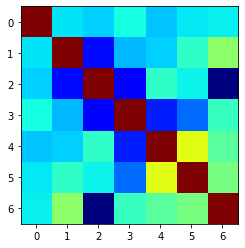

In [49]:
corr_matrix = corr_matrix = titanic_train.corr()
plt.imshow(corr_matrix,cmap='jet',interpolation='nearest')

In [50]:
corr_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [37]:
corr_matrix = titanic_train.groupby("Survived").corr()

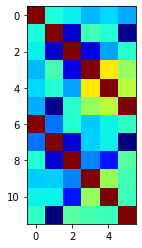

In [48]:
corr_matrix
plt.imshow(corr_matrix,cmap='jet',interpolation='nearest')

Surviving people are computed in function of their Pclass

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Pclass, dtype: object

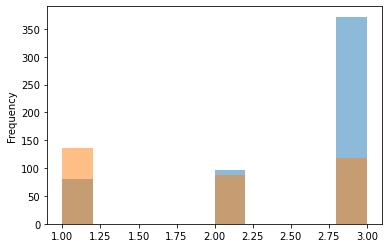

In [37]:
titanic_train.groupby("Survived").Pclass.plot(kind="hist",stacked=True,alpha=0.5)


In [37]:
titanic_train.groupby("Survived").Pclass.value_counts(normalize=True).sort_index()

Survived  Pclass
0         1         0.145719
          2         0.176685
          3         0.677596
1         1         0.397661
          2         0.254386
          3         0.347953
Name: Pclass, dtype: float64

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Sex, dtype: object

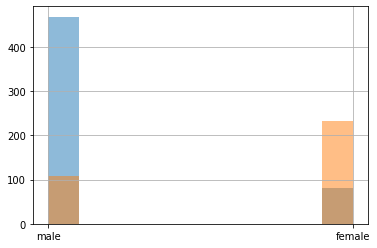

In [15]:
titanic_train.groupby("Survived").Sex.hist(stacked=True,alpha=0.5)

In [38]:
titanic_train.groupby("Survived").Sex.value_counts(normalize=True).sort_index()

Survived  Sex   
0         female    0.147541
          male      0.852459
1         female    0.681287
          male      0.318713
Name: Sex, dtype: float64

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

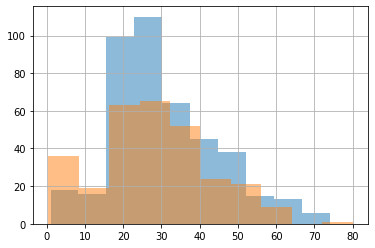

In [47]:
titanic_train.groupby("Survived").Age.hist(alpha=0.5, label=True)

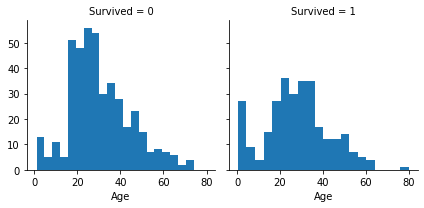

In [6]:
g = sns.FacetGrid(titanic_train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


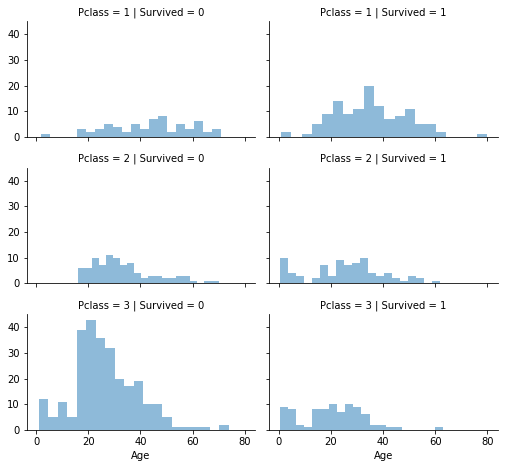

In [7]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(titanic_train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/seaborn/axisgrid.py:650: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


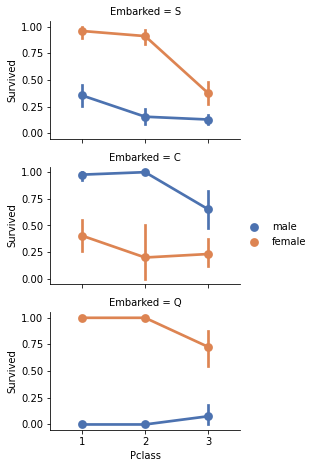

In [8]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(titanic_train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

3.Modify and adapt more convenient features for the dataset
----
----

We get rid of cabin feature as there are to few instances, we also get rid of name feature as it is too complex as feature to interpret for the model

In [36]:
titanic_train.drop('Cabin', inplace=True, axis="columns")

In [37]:
titanic_train.drop('Name', inplace=True, axis="columns")

In [53]:
titanic_train.drop('Ticket', inplace=True, axis="columns") 
# Could be useful but too hard to find a pattern

We split the age in bins as it seems there are groups of age for the survival (in order to symplify the model

In [38]:
# Fill the Age cat with median
titanic_train["Age"].fillna(titanic_train["Age"].median(), inplace=True)
titanic_train["Age_slice"] = pd.cut(titanic_train["Age"], bins=[0, 15, 30, 40, 50, 60, 70, 100], labels=[0,15,30,40,50,60,80])

We change the sex feature from string to numbers, with Onehotencoder

In [55]:
sex_1_hot = cat_encoder.fit_transform(titanic_train[['Sex']])

In [57]:
sex_1_hot.toarray()

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

We add OneHotEncoder for the embarked port attributes

In [49]:
titanic_train['Embarked'].fillna(value='S', inplace=True)

cat_encoder = OneHotEncoder()
titanic_train_1_hot = cat_encoder.fit_transform(titanic_train[['Embarked']])
titanic_train_1_hot.toarray()

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [54]:
titanic_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_slice
0,1,0,3,1,22.0,1,0,7.2500,S,15
1,2,1,1,0,38.0,1,0,71.2833,C,30
2,3,1,3,0,26.0,0,0,7.9250,S,15
3,4,1,1,0,35.0,1,0,53.1000,S,30
4,5,0,3,1,35.0,0,0,8.0500,S,30


3.Synthesis of operations on instances in pipelines
----
----

In [17]:
titanic_train_num = titanic_train[["Pclass", 'Parch', 'SibSp', 'Fare','Age']]
titanic_train_cat = titanic_train[['Sex', 'Embarked']]

In [63]:
titanic_train_num.head()

,Pclass,Age,Parch,SibSp,Fare
0,3,22.0,0,1,7.2500
1,1,38.0,0,1,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,0,1,53.1000
4,3,35.0,0,0,8.0500


In [25]:
titanic_train.groupby("Pclass").Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


In [20]:
Age_index, Fare_index = 4, 3

class BinsAgeFare(BaseEstimator, TransformerMixin):
    def __init__(self, sliced_age = True): #No *args or **kwargs
        self.sliced_age = sliced_age
    
    def fit(self, X, y=None):
        return self #nothing else to do
    
    def transform(self, X):
        # Fare are put in slice of prices 
        #TODO determine slice of prices 
        X_Fare_bin = pd.cut(X[:,Fare_index], bins=[-np.inf, 7.500, 15.000, 30.000, 70.000, 95.000, np.inf], labels=[0,1,2,3,4,5])
        if self.sliced_age:
            Age_sliced = pd.cut(X[:, Age_index], bins=[0., 15., 30., 40., 50., 60., 70.,np.inf], labels=[0,15,30,40,50,60,80])
            return np.c_[X[:,0:Fare_index], X_Fare_bin, Age_sliced]
        else:
            return np.c_[X[:, 0:Fare_index], X_Fare_bin]

In [30]:
Num_pipeline = Pipeline([
    ("imputer", SimpleImputer(missing_values = np.nan, strategy = "median")), # fill all missing numerical value with median
    ("bins_age_fare", BinsAgeFare(sliced_age=False)),
    ("standard_scaler", StandardScaler())
])

In [31]:
titanic_train_num_proc = Num_pipeline.fit_transform(titanic_train_num)
titanic_train_num_proc

array([[ 0.82737724, -0.47367361,  0.43279337, -1.40593392],
       [-1.56610693, -0.47367361,  0.43279337,  1.670032  ],
       [ 0.82737724, -0.47367361, -0.4745452 , -0.63694244],
       ...,
       [ 0.82737724,  2.00893337,  0.43279337,  0.13204904],
       [-1.56610693, -0.47367361, -0.4745452 ,  0.13204904],
       [ 0.82737724, -0.47367361, -0.4745452 , -0.63694244]])

In [32]:
np.count_nonzero(~np.isnan(titanic_train_num_proc))

3564

In [33]:
np.size(titanic_train_num_proc)

3564

In [8]:
titanic_train_num_proc

array([[ 0.82737724, -0.56573646, -0.47367361,  0.43279337, -0.93323487,
        -0.46147956],
       [-1.56610693,  0.66386103, -0.47367361,  0.43279337,  1.78999546,
         0.60374917],
       [ 0.82737724, -0.25833709, -0.47367361, -0.4745452 , -0.93323487,
        -0.46147956],
       ...,
       [ 0.82737724, -0.1046374 ,  2.00893337,  0.43279337,  0.15605726,
        -0.46147956],
       [-1.56610693, -0.25833709, -0.47367361, -0.4745452 ,  0.15605726,
        -0.46147956],
       [ 0.82737724,  0.20276197, -0.47367361, -0.4745452 , -0.93323487,
         0.60374917]])

In [34]:
Embarked_index = 1

class EmbarkedDataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value 
        in column.
        """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        new_X = X.apply(lambda x: x.fillna(x.value_counts().index[0]))
        return np.c_[new_X]


In [35]:
Cat_pipeline = Pipeline([
    ("fill_embarked", EmbarkedDataFrameImputer()),
    ("one_hot", OneHotEncoder())
])

In [36]:
titanic_train_cat_tr = Cat_pipeline.fit_transform(titanic_train_cat)

In [37]:
np.size(titanic_train_num_proc)

3564

In [12]:
titanic_train_cat_tr[:10, :6].toarray()

array([[0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0.]])

In [38]:
num_attribs = list(titanic_train_num)
cat_attribs = list(titanic_train_cat)

Full_pipeline = ColumnTransformer([
    ("num_pipeline", Num_pipeline, num_attribs),
    ("cat_pipeline", Cat_pipeline, cat_attribs)
])

In [39]:
titanic_train_prepared = Full_pipeline.fit_transform(titanic_train)

In [40]:
# The model has to predict if the passenger will survive or no, so Survived columns is prediction
X_train = titanic_train_prepared
y_train = titanic_train["Survived"]

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict

In [74]:
def plot_precision_recall_vs_threshold(y_train, y_predict):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_predict)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.grid()
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()

In [61]:
def plot_roc_curve(y_train, y_predict):
    fpr, tpr, thresholds = roc_curve(y_train, y_predict)
    plt.plot(fpr, tpr, 'b', linewidth=2)
    plt.plot([0,1], [0,1], 'k--') #Dashed diagonal
    plt.grid("on")
    plt.ylabel('tpr')
    plt.xlabel('fpr')

In [76]:
def display_score(model):
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10)
    y_predict = cross_val_predict(model, X_train, y_train, cv=10)
    
    print("Scores : ", score)
    print("Mean : ", score.mean())
    print("Standard deviation :", score.std())
    print("Confusion Matrix : \n", confusion_matrix(y_train, y_predict))
    print("Precision : ", precision_score(y_train, y_predict))
    print("Recall : ",recall_score(y_train, y_predict))
    print("F1_score", f1_score(y_train, y_predict))
    print("ROC Area Under Curve :", roc_auc_score(y_train, y_predict))
    
    plot_precision_recall_vs_threshold(y_train, y_predict)
    plot_roc_curve(y_train, y_predict)

In [42]:
sgd_clf = SGDClassifier(random_state=42)

In [44]:
some_value = X_train[10]

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_value])

array([1])

In [52]:
titanic_train.iloc[10]

PassengerId                                 11
Survived                                     1
Pclass                                       3
Name           Sandstrom, Miss. Marguerite Rut
Sex                                     female
Age                                          4
SibSp                                        1
Parch                                        1
Ticket                                 PP 9549
Fare                                      16.7
Cabin                                       G6
Embarked                                     S
Name: 10, dtype: object

Scores :  [0.75555556 0.73033708 0.69662921 0.80898876 0.76404494 0.7752809
 0.78651685 0.79775281 0.79775281 0.7752809 ]
Mean :  0.7688139825218477
Standard deviation : 0.03252014871401163
Confusion Matrix : 
 [[461  88]
 [118 224]]
Precision :  0.717948717948718
Recall :  0.6549707602339181
F1_score 0.6850152905198776
ROC Area Under Curve : 0.7473396606269772


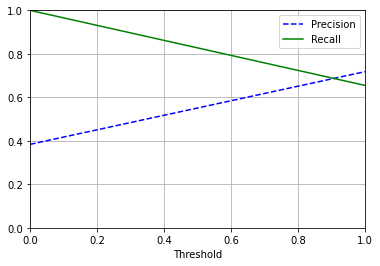

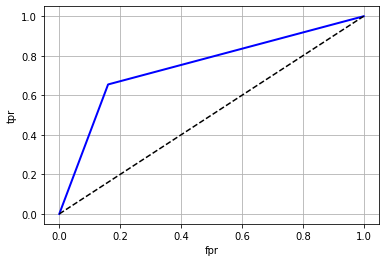

In [77]:
display_score(sgd_clf)

In [87]:
def prepare_dataset(titanic_set):
    titanic_set_prepared = Full_pipeline.fit_transform(titanic_set)
    return (titanic_set_prepared)

In [88]:
X_test = prepare_dataset(titanic_test)

In [89]:
sgd_clf.predict(X_test)

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,